# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


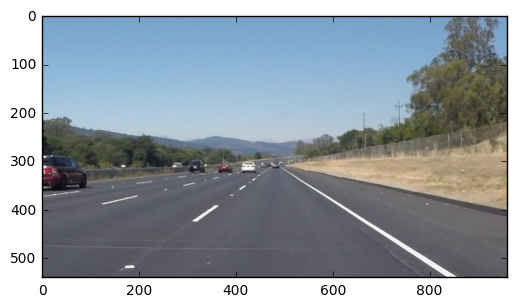

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

'''
    Global states for intercepts, slopes and the top_y
'''
pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = np.array([])
top_y = np.array([])

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    auto = canny(image, lower, upper)
    return auto

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def yellow_to_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of yellow color in HSV
    upper_yellow = np.array([100, 255, 255]) 
    lower_yellow = np.array([80, 100, 100]) 

    # Threshold the HSV image to get only yellow colors
    mask_inverse = cv2.inRange(hsv, lower_yellow, upper_yellow)    
    masked_replace_white = cv2.addWeighted(img, 1, \
                                       cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB), 1, 0)
    #mask3 = np.dstack((mask_inverse, mask_inverse, mask_inverse)) 
    #max_image = cv2.max(img, mask3)

    return masked_replace_white


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    注意：这是您想要用作起点的功能
     平均/外插您检测到的线段以映射出完整的
     （从raw-lines-example.mp4中显示的结果开始）
     到P1_example.mp4中所示）。
    
     想想用它们分隔线段的事情
     斜率（（y2-y1）/（x2-x1））以确定哪些段是左边的一部分
     线对右线。 然后，您可以平均每个的位置
     线和外推到车道的顶部和底部。
    
     这个函数用`color`和`thickness`绘制`lines`。
     在图像上绘制线条（突变图像）。
     如果你想使线条半透明，想想组合
     这个函数用以下的weighted_img（）函数
    """
    for line in lines:        
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    #print("Average : %%", total_pos_slope/pos_slope, total_neg_slope/neg_slope)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    extrapolate(line_img, lines)
    #draw_lines(line_img, lines)
    return line_img

def lines_linreg(lines_array):  
    '''
        计算线段的斜率和截距
    '''
    try:
        ### 选择第0和第2个索引，它们将提供xval和重塑以提取x值
        x = np.reshape(lines_array[:, [0, 2]], (1, len(lines_array) * 2))[0]
        ### 选择第一个和第三个索引，它将提供yval和重塑以提取y值
        y = np.reshape(lines_array[:, [1, 3]], (1, len(lines_array) * 2))[0]

        A = np.vstack([x, np.ones(len(x))]).T
        ###估计线性模型中的系数
        m, c = np.linalg.lstsq(A, y)[0]
        x = np.array(x)
        y = np.array(x * m + c).astype('int')
    except:
        print(x,y)
    return x, y, m, c

def mad(data, axis=None):
    return np.mean(np.abs(data - np.mean(data, axis)), axis)

def extrapolate(img, lines): 
    '''
        This function extrapolates the line segment consider the slope and intercept
        for the left and right line segments.
    '''
    global pos_global_slopes
    global pos_global_intercepts
    global neg_global_slopes
    global neg_global_intercepts
    global top_y
    
    max_height = img.shape[0]
    max_width = img.shape[1]
    if lines == None:
        print("******************* No lines detected")
        return
    slopes = np.apply_along_axis(lambda row: (row[3] - row[1])/(row[2] - row[0]), 2, lines)
    
    pos_slopes = slopes > 0.50
    pos_lines = lines[pos_slopes]

    neg_slopes = slopes < -0.50
    neg_lines = lines[neg_slopes]
    
    if len(pos_lines) == 0 or len(neg_lines) == 0:
        return;
    
    pos_x, pos_y, pos_m, pos_c = lines_linreg(pos_lines)
    pos_global_slopes = np.append(pos_global_slopes, [pos_m])
    pos_global_intercepts = np.append(pos_global_intercepts, [pos_c])

    #print("Before adjusting slopes : %f intercept %f" % (pos_m, pos_c))
    pos_m = pos_global_slopes[-20:].mean()
    pos_c = pos_global_intercepts[-20:].mean()
    
    #print("------------")
    
    neg_x, neg_y, neg_m, neg_c = lines_linreg(neg_lines)
    neg_global_slopes = np.append(neg_global_slopes, [neg_m])
    neg_global_intercepts = np.append(neg_global_intercepts, [neg_c])
    neg_m = neg_global_slopes[-20:].mean()
    neg_c = neg_global_intercepts[-20:].mean()
    
    bottom_left_y = img.shape[0]
    bottom_left_x = int((bottom_left_y - neg_c)/neg_m)
    
    min_top_y = np.min([neg_y.min(), pos_y.min()])
    top_y = np.append(top_y, [min_top_y])
    min_top_y = int(top_y[-20:].mean())
    top_left_y = min_top_y
    top_left_x = int((top_left_y - neg_c)/neg_m)
    
    top_right_y = min_top_y
    top_right_x = int((top_right_y - pos_c)/pos_m)
    
    bottom_right_y = img.shape[0]
    bottom_right_x = int((bottom_right_y - pos_c)/pos_m)
    
    #Average    
    cv2.line(img, (bottom_left_x, bottom_left_y), (top_left_x, top_left_y), [0, 255, 0], 10)
    cv2.line(img, (top_right_x, top_right_y), (bottom_right_x, bottom_right_y), [0, 255, 0], 10)

    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    converted = yellow_to_white(image)
    max_width = image.shape[1]
    max_height = image.shape[0]
    sample_image = np.copy(converted)
    width_delta = int(max_width/20)
    vertices = np.array([[(100, max_height), (max_width -100, max_height), (max_width/2 + width_delta, max_height/2 + 50), (max_width/2 - width_delta, max_height/2 + 50)]], np.int32)

    gray_scaled = grayscale(sample_image)
    blurred_img = gaussian_blur(gray_scaled, 5)
    #cimage = canny(blurred_img, 50, 250)
    # Use auto_canny instead.
    cimage = auto_canny(blurred_img)
    tmp = np.copy(cimage)
    selected = region_of_interest(cimage, vertices)
    fin = hough_lines(selected, 1, 1 * np.pi/180, 20, 5, 5)

    result = weighted_img(fin, image, α=0.8, β=1., λ=0.)

    return result

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

/root/miniconda3/envs/carnd_term_1/lib/python3.5/site-packages/ipykernel/__main__.py:142: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


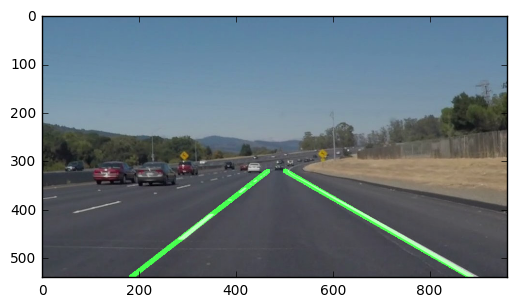

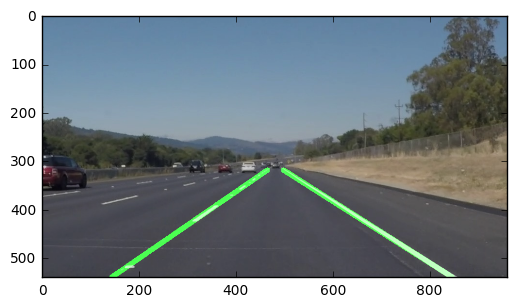

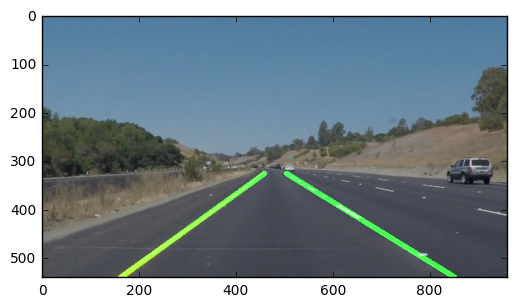

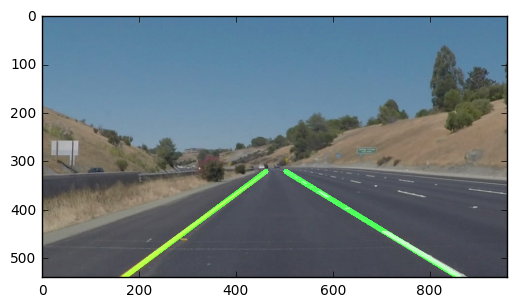

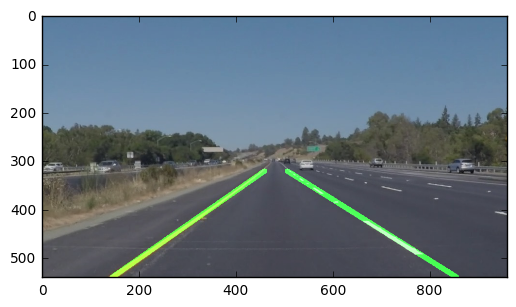

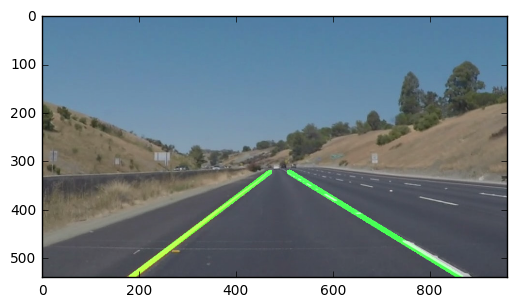

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
imgs = []
for img in os.listdir("test_images/"):
    pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = np.array([])
    top_y = np.array([])
    test_image = mpimg.imread('test_images/'+img)
    t = process_image(test_image)
    plt.imshow(t)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = top_y =  np.array([])

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:15<00:00, 14.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 10.2 s, sys: 600 ms, total: 10.8 s
Wall time: 16.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = top_y = np.array([])
pos_cache, neg_cache = [],[]

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:50<00:00, 13.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 32.4 s, sys: 1.23 s, total: 33.6 s
Wall time: 52.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
pos_global_slopes = pos_global_intercepts = neg_global_slopes = neg_global_intercepts = top_y = np.array([])
pos_cache, neg_cache = [],[]

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:35<00:00,  7.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 20.5 s, sys: 1.62 s, total: 22.1 s
Wall time: 38.7 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))